## Conclusion

The Pearson correlation coefficient test results indicate the strength and significance of the relationships between different variables. In this analysis:

- **The strongest correlation is observed between Palace and Metropolitan examinations, with a correlation coefficient of 0.182584, indicating a comparitive moderate positive correlation. This correlation is highly statistically significant with a p-value of 3.097262e-101.**

- The correlation coefficient between Metropolitan and Provincial examinations is 0.075779, suggesting a weak positive correlation, which is statistically significant with a p-value of 1.326249e-18.
  
- The correlation coefficient between Palace and Provincial examinations is 0.043199, indicating a similarly weak positive correlation, also statistically significant with a p-value of 5.340735e-07.



| Relationship            | Correlation Coefficient | p-value            |
|-------------------------|-------------------------|--------------------|
| Metropolitan vs Provincial | 0.075779                | 1.326249e-18       |
| Palace vs Provincial       | 0.043199                | 5.340735e-07       |
| Palace vs Metropolitan     | 0.182584                | 3.097262e-101      |


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Read the source data

In [2]:
input_data_df = pd.read_excel('ming_jinshilu_52y_release.xlsx', sheet_name='Ming Jinshi Lists')

# only keep ID_MING_JINSHI, CBDB_personid, 姓名, 甲次, 名次, 鄉試名次, 會試名次, 進士年份
input_data_df = input_data_df[['ID_MING_JINSHI', 'CBDB_personid', '姓名', '甲次', '名次', '鄉試名次', '會試名次', '進士年份']]

# rename columns to 'ID_MING_JINSHI', 'personid', 'name', 'p_rank_1', 'p_rank_2', p_rank', 'm_rank'
input_data_df.columns = ['ID_MING_JINSHI', 'personid', 'name', 'pl_rank_1', 'pl_rank_2', 'pr_rank', 'me_rank', 'entry_year']

print(input_data_df.shape)

input_data_df.head()

(14116, 8)


,ID_MING_JINSHI,personid,name,pl_rank_1,pl_rank_2,pr_rank,me_rank,entry_year
0,JINSHI_1-120.csv_1,34414,吳伯宗,第一甲,第一名,第一名,第二十四名,1371
1,JINSHI_1-120.csv_2,198025,郭翀,第一甲,第二名,第八名,第五十一名,1371
2,JINSHI_1-120.csv_3,198026,吳公達,第一甲,第三名,第二十九名,第一百十五名,1371
3,JINSHI_1-120.csv_4,66504,楊自立,第二甲,第一名,第八名,第三名,1371
4,JINSHI_1-120.csv_5,198027,趙友能,第二甲,第二名,第二十八名,第七十三名,1371


## Create arabic numbers Chinese mapping for pa, pr, and me ranks

### Create 甲次 jiaci mapping

In [3]:
# Find unique values in pl_rank_1
jiaci_unique = input_data_df['pl_rank_1'].unique()
print(jiaci_unique)

# Create a dictionary to map the jiaci to a number
jiaci_dict = {'第一甲': 1, '第二甲': 2, '第三甲': 3, '第仕至二甲': 2, '第乙未殿試二甲': 2}

['第一甲' '第二甲' '第三甲' nan '第仕至二甲' '第乙未殿試二甲']


### Create 名次 mingci mapping

In [4]:
# Combine pl_rank_2, pr_rank, me_rank together, keep the unique values
rank_unique = input_data_df[['pl_rank_2', 'pr_rank', 'me_rank']].stack().unique()
# save the unique values to a txt file
with open('rank_unique.txt', 'w') as f:
    for item in rank_unique:
        f.write("%s\n" % item)
print(rank_unique.shape)
rank_unique[:10]

(3297,)


array(['第一名', '第二十四名', '第二名', '第八名', '第五十一名', '第三名', '第二十九名', '第一百十五名',
       '第二十八名', '第七十三名'], dtype=object)

In [5]:
rank_unique_cleaned = []
# In rank_unique
# 1. Use regex to remove "^.*試" and ^.*第 from the string
# 2. Remove "　" and " " from the string
# 3. Skip the string if it contains "□"
# 4. Remove 名
# 5. If there is no 一二三四五六七八九十百 in the string, skip the string
import re
for rank in rank_unique:
    # specific rules
    rank = rank.replace('一百三十五名未廷試', '一百三十五')
    rank = rank.replace('叄', '三')
    rank = rank.replace('、', '')
    rank = rank.replace('士一', '十一')
    rank = re.sub('台$', '', rank)

    # general rules
    rank = re.sub('^.*試', '', rank)
    rank = re.sub('^.*第', '', rank)
    rank = rank.replace('　', '')
    rank = rank.replace(' ', '')
    rank = rank.replace('名', '')
    if '□' in rank:
        rank = ''
    if not re.search('[一二三四五六七八九十百]', rank) and rank != '':
        # rank = "no_number"
        rank = ""
    rank_unique_cleaned.append(rank)

# save rank_unique and rank_unique_cleaned to two columns in a csv file
rank_unique_df = pd.DataFrame({'rank_unique': rank_unique, 'rank_unique_cleaned': rank_unique_cleaned})
rank_unique_df.to_csv('rank_unique.csv', index=False, encoding='utf-8-sig')
rank_unique_df.head()

,rank_unique,rank_unique_cleaned
0,第一名,一
1,第二十四名,二十四
2,第二名,二
3,第八名,八
4,第五十一名,五十一


In [6]:
# Print the unique number of rank_unique_cleaned
rank_unique_cleaned_unique = list(set(rank_unique_cleaned))
# Remove the empty string
rank_unique_cleaned_unique.remove('')
print(len(rank_unique_cleaned_unique))
# save the unique values to a txt file
with open('rank_unique_cleaned_unique.txt', 'w') as f:
    for item in rank_unique_cleaned_unique:
        f.write("%s\n" % item)


467


## Create number column for input_data_df

In [7]:
number_mapping_df = pd.read_excel('number_mapping_from_llm.xlsx', sheet_name='data')
number_mapping_df.head()

# Create a dictionary to map the rank to a number
rank_dict = {}
for index, row in number_mapping_df.iterrows():
    rank_dict[row['rank']] = row['number']

# Add number columns to the rank_unique_df
rank_unique_df['number'] = rank_unique_df['rank_unique_cleaned'].map(rank_dict)

# Create a dictionary to map the rank_unique to a number
rank_unique_dict = {}
for index, row in rank_unique_df.iterrows():
    rank_unique_dict[row['rank_unique']] = row['number']

for key in list(rank_unique_dict.keys())[:10]:
    print(key, rank_unique_dict[key])

第一名 1.0
第二十四名 24.0
第二名 2.0
第八名 8.0
第五十一名 51.0
第三名 3.0
第二十九名 29.0
第一百十五名 115.0
第二十八名 28.0
第七十三名 73.0


In [8]:
# Add number columns to the input_data_df
input_data_df['pl_rank_1_number'] = input_data_df['pl_rank_1'].map(jiaci_dict)
input_data_df['pl_rank_2_number'] = input_data_df['pl_rank_2'].map(rank_unique_dict)
input_data_df['pr_rank_number'] = input_data_df['pr_rank'].map(rank_unique_dict)
input_data_df['me_rank_number'] = input_data_df['me_rank'].map(rank_unique_dict)

input_data_df.head()

,ID_MING_JINSHI,personid,name,pl_rank_1,pl_rank_2,pr_rank,me_rank,entry_year,pl_rank_1_number,pl_rank_2_number,pr_rank_number,me_rank_number
0,JINSHI_1-120.csv_1,34414,吳伯宗,第一甲,第一名,第一名,第二十四名,1371,1.0,1.0,1.0,24.0
1,JINSHI_1-120.csv_2,198025,郭翀,第一甲,第二名,第八名,第五十一名,1371,1.0,2.0,8.0,51.0
2,JINSHI_1-120.csv_3,198026,吳公達,第一甲,第三名,第二十九名,第一百十五名,1371,1.0,3.0,29.0,115.0
3,JINSHI_1-120.csv_4,66504,楊自立,第二甲,第一名,第八名,第三名,1371,2.0,1.0,8.0,3.0
4,JINSHI_1-120.csv_5,198027,趙友能,第二甲,第二名,第二十八名,第七十三名,1371,2.0,2.0,28.0,73.0


In [9]:
# Create pl_rank by combining pl_rank_1_number as integer, and pl_rank_2_number as decimal
input_data_df['pl_rank_number'] = input_data_df['pl_rank_1_number'] + input_data_df['pl_rank_2_number'] / 1000

input_data_df.head()

,ID_MING_JINSHI,personid,name,pl_rank_1,pl_rank_2,pr_rank,me_rank,entry_year,pl_rank_1_number,pl_rank_2_number,pr_rank_number,me_rank_number,pl_rank_number
0,JINSHI_1-120.csv_1,34414,吳伯宗,第一甲,第一名,第一名,第二十四名,1371,1.0,1.0,1.0,24.0,1.001
1,JINSHI_1-120.csv_2,198025,郭翀,第一甲,第二名,第八名,第五十一名,1371,1.0,2.0,8.0,51.0,1.002
2,JINSHI_1-120.csv_3,198026,吳公達,第一甲,第三名,第二十九名,第一百十五名,1371,1.0,3.0,29.0,115.0,1.003
3,JINSHI_1-120.csv_4,66504,楊自立,第二甲,第一名,第八名,第三名,1371,2.0,1.0,8.0,3.0,2.001
4,JINSHI_1-120.csv_5,198027,趙友能,第二甲,第二名,第二十八名,第七十三名,1371,2.0,2.0,28.0,73.0,2.002


## Clean data for correlation calculation

In [10]:
# Drop 'pl_rank_1', 'pl_rank_2', 'pr_rank', 'me_rank', 'pl_rank_1_number', 'pl_rank_2_number'
input_data_df = input_data_df.drop(columns=['pl_rank_1', 'pl_rank_2', 'pr_rank', 'me_rank', 'pl_rank_1_number', 'pl_rank_2_number'])
# Delete the rows if any values in pr_rank_number	me_rank_number	pl_rank_number are empty
input_data_df = input_data_df.dropna(subset=['pr_rank_number', 'me_rank_number', 'pl_rank_number'])

print(input_data_df.shape)
input_data_df.head()

(13460, 7)


,ID_MING_JINSHI,personid,name,entry_year,pr_rank_number,me_rank_number,pl_rank_number
0,JINSHI_1-120.csv_1,34414,吳伯宗,1371,1.0,24.0,1.001
1,JINSHI_1-120.csv_2,198025,郭翀,1371,8.0,51.0,1.002
2,JINSHI_1-120.csv_3,198026,吳公達,1371,29.0,115.0,1.003
3,JINSHI_1-120.csv_4,66504,楊自立,1371,8.0,3.0,2.001
4,JINSHI_1-120.csv_5,198027,趙友能,1371,28.0,73.0,2.002


# Calculate pearsonr for pr_rank_number	me_rank_number	pl_rank_number

In [11]:
from scipy.stats import pearsonr
pr_rank_number = input_data_df['pr_rank_number']
me_rank_number = input_data_df['me_rank_number']
pl_rank_number = input_data_df['pl_rank_number']
pearsonr_me_pr = pearsonr(me_rank_number, pr_rank_number)
pearsonr_pl_pr = pearsonr(pl_rank_number, pr_rank_number)
pearsonr_pl_me = pearsonr(pl_rank_number, me_rank_number)

# calculate the correlation coefficient between pr_rank_number and me_rank_number
index_names = ['metropolitan_provincial', 'palace_provincial', 'palace_metropolitan']
correlation_coefficient = [pearsonr_me_pr[0], pearsonr_pl_pr[0], pearsonr_pl_me[0]]
correlation_p_value = [pearsonr_me_pr[1], pearsonr_pl_pr[1], pearsonr_pl_me[1]]
correlation_df = pd.DataFrame({'correlation_coefficient': correlation_coefficient, 'p_value': correlation_p_value}, index=index_names)

correlation_df

,correlation_coefficient,p_value
metropolitan_provincial,0.075779,1.326249e-18
palace_provincial,0.043199,5.340735e-07
palace_metropolitan,0.182584,3.097262e-101


## The number one in me, the histogram of the pr ranks

<AxesSubplot:xlabel='pr_rank_number', ylabel='Frequency'>

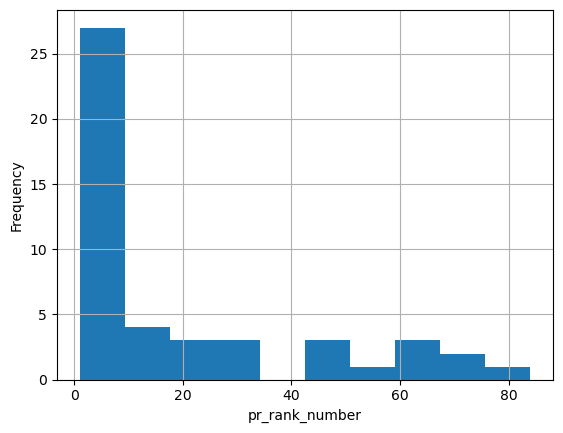

In [12]:
# When me_rank_number = 1.0, the distribution the pr_rank_number
input_data_df_me_rank_1 = input_data_df[input_data_df['me_rank_number'] == 1.0]
plt.xlabel('pr_rank_number')
plt.ylabel('Frequency')
input_data_df_me_rank_1['pr_rank_number'].hist()

In [13]:
# Calculate the rate of pr_rank_number < 10 and pr_rank_number >= 10 AKA 會試第一名來自鄉試前十名的比例
pr_rank_number_lt_10 = input_data_df_me_rank_1[input_data_df_me_rank_1['pr_rank_number'] < 10].shape[0]
pr_rank_number_ge_10 = input_data_df_me_rank_1[input_data_df_me_rank_1['pr_rank_number'] >= 10].shape[0]
pr_rank_number_lt_10_rate = pr_rank_number_lt_10 / (pr_rank_number_lt_10 + pr_rank_number_ge_10)
pr_rank_number_ge_10_rate = pr_rank_number_ge_10 / (pr_rank_number_lt_10 + pr_rank_number_ge_10)

pr_rank_number_lt_10_rate, pr_rank_number_ge_10_rate

(0.574468085106383, 0.425531914893617)

<AxesSubplot:xlabel='pr_rank_number', ylabel='Frequency'>

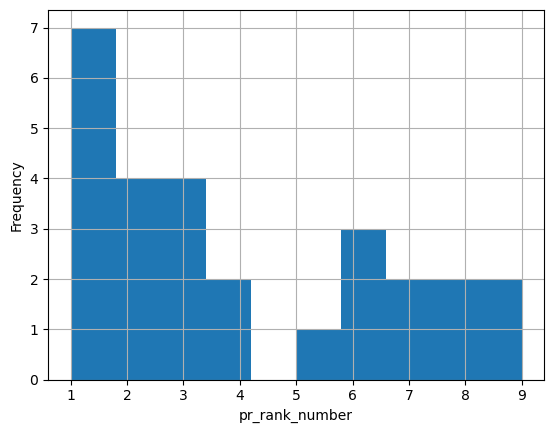

In [14]:
# Only keep the rows with pr_rank_number <= 10 AKA 會試第一名在鄉試前十名的分佈
input_data_df_me_rank_1_pr_less_than_10 = input_data_df_me_rank_1[input_data_df_me_rank_1['pr_rank_number'] <= 10]
plt.xlabel('pr_rank_number')
plt.ylabel('Frequency')
input_data_df_me_rank_1_pr_less_than_10['pr_rank_number'].hist()

## The number one in pr, the histogram of the me ranks

<AxesSubplot:xlabel='me_rank_number', ylabel='Frequency'>

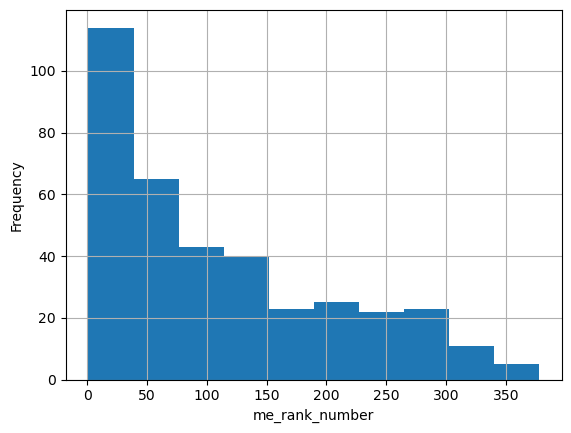

In [15]:
# Draw the number on in pr, the Histogram of the me ranks
input_data_df_pr_rank_1 = input_data_df[input_data_df['pr_rank_number'] == 1.0]
plt.xlabel('me_rank_number')
plt.ylabel('Frequency')
input_data_df_pr_rank_1['me_rank_number'].hist()

In [16]:
# Calculate the rate of pm_rank_number < 10 and pm_rank_number >= 10 AKA 鄉試第一名能進會試前十名的比率
me_rank_number_lt_10 = input_data_df_pr_rank_1[input_data_df_pr_rank_1['me_rank_number'] < 10].shape[0]
me_rank_number_ge_10 = input_data_df_pr_rank_1[input_data_df_pr_rank_1['me_rank_number'] >= 10].shape[0]
me_rank_number_lt_10_rate = me_rank_number_lt_10 / (me_rank_number_lt_10 + me_rank_number_ge_10)
me_rank_number_ge_10_rate = me_rank_number_ge_10 / (me_rank_number_lt_10 + me_rank_number_ge_10)

me_rank_number_lt_10_rate, me_rank_number_ge_10_rate

(0.09703504043126684, 0.9029649595687331)

<AxesSubplot:xlabel='me_rank_number', ylabel='Frequency'>

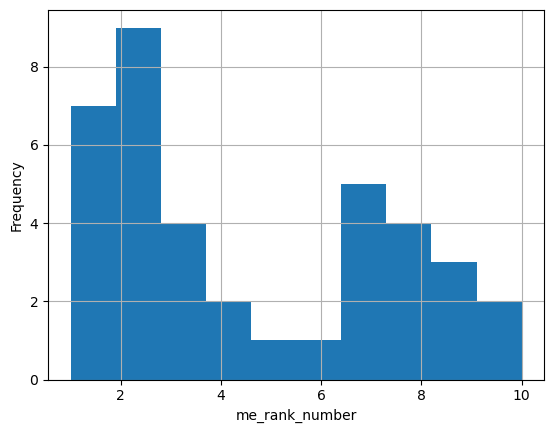

In [17]:
# Only keep the rows with me_rank_number <= 10 AKA 鄉試第一名在會試名次前十名的分佈
input_data_df_pr_rank_1_me_less_than_10 = input_data_df_pr_rank_1[input_data_df_pr_rank_1['me_rank_number'] <= 10]
plt.xlabel('me_rank_number')
plt.ylabel('Frequency')
input_data_df_pr_rank_1_me_less_than_10['me_rank_number'].hist()

## Top 1%, 5%, 10% in me, the histogram of the pr ranks

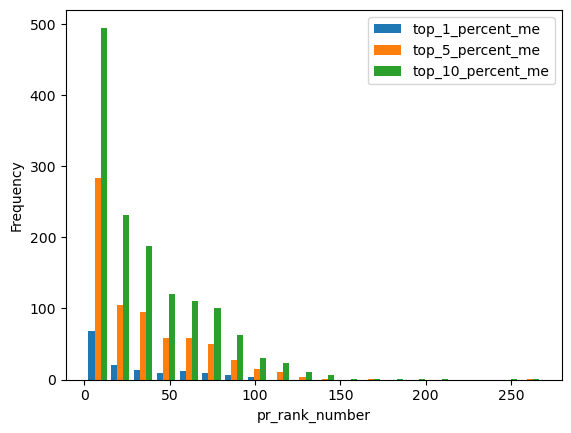

In [18]:
## Top 1%, 5%, 10% in me, the Histogram of the pr ranks
top_1_percent_me = input_data_df[input_data_df['me_rank_number'] <= input_data_df['me_rank_number'].quantile(0.01)]

top_5_percent_me = input_data_df[input_data_df['me_rank_number'] <= input_data_df['me_rank_number'].quantile(0.05)]

top_10_percent_me = input_data_df[input_data_df['me_rank_number'] <= input_data_df['me_rank_number'].quantile(0.10)]

# draw the histogram of top_1_percent_me, top_5_percent_me, top_10_percent_me together
plt.hist([top_1_percent_me['pr_rank_number'],  top_5_percent_me['pr_rank_number'], top_10_percent_me['pr_rank_number']], bins=20, label=['top_1_percent_me', 'top_5_percent_me', 'top_10_percent_me'])
plt.legend(loc='upper right')
plt.xlabel('pr_rank_number')
plt.ylabel('Frequency')
plt.show()

## Last 1%, 5%, 10% in me, the histogram of the pr ranks

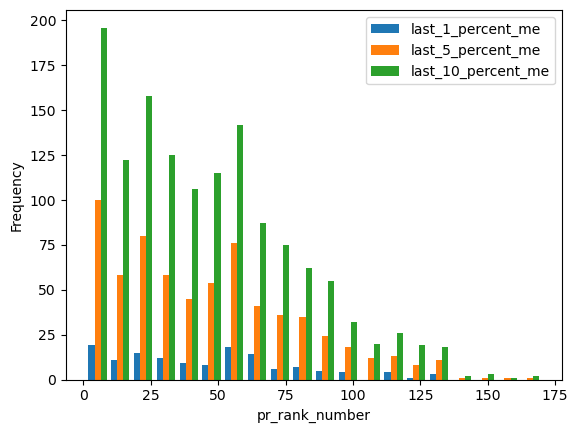

In [19]:
last_1_percent_me = input_data_df[input_data_df['me_rank_number'] >= input_data_df['me_rank_number'].quantile(0.99)]

last_5_percent_me = input_data_df[input_data_df['me_rank_number'] >= input_data_df['me_rank_number'].quantile(0.95)]

last_10_percent_me = input_data_df[input_data_df['me_rank_number'] >= input_data_df['me_rank_number'].quantile(0.90)]

plt.hist([last_1_percent_me['pr_rank_number'],  last_5_percent_me['pr_rank_number'], last_10_percent_me['pr_rank_number']], bins=20, label=['last_1_percent_me', 'last_5_percent_me', 'last_10_percent_me'])
plt.legend(loc='upper right')
plt.xlabel('pr_rank_number')
plt.ylabel('Frequency')
plt.show()

## Top 1%, 5%, 10% in pr, the histogram of the me ranks

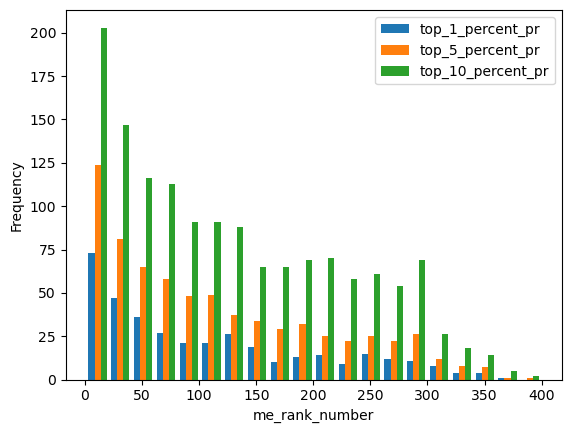

In [20]:
top_1_percent_pr = input_data_df[input_data_df['pr_rank_number'] <= input_data_df['pr_rank_number'].quantile(0.01)]

top_5_percent_pr = input_data_df[input_data_df['pr_rank_number'] <= input_data_df['pr_rank_number'].quantile(0.05)]

top_10_percent_pr = input_data_df[input_data_df['pr_rank_number'] <= input_data_df['pr_rank_number'].quantile(0.1)]

plt.hist([top_1_percent_pr['me_rank_number'], top_5_percent_pr['me_rank_number'], top_10_percent_pr['me_rank_number']], bins=20, label=['top_1_percent_pr', 'top_5_percent_pr', 'top_10_percent_pr'])
plt.legend(loc='upper right')
plt.xlabel('me_rank_number')
plt.ylabel('Frequency')
plt.show()



## Last 1%, 5%, 10% in pr, the histogram of the me ranks

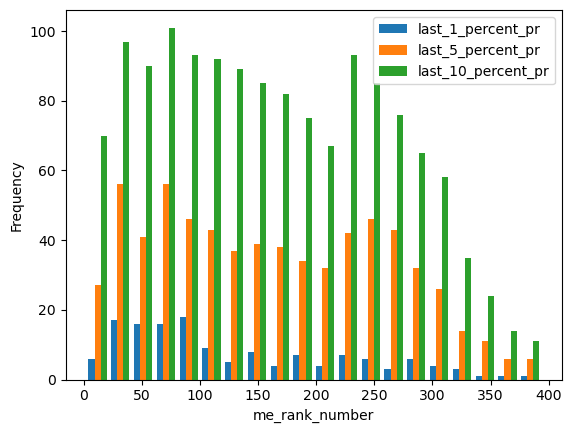

In [21]:
last_1_percent_pr = input_data_df[input_data_df['pr_rank_number'] >= input_data_df['pr_rank_number'].quantile(0.99)]

last_5_percent_pr = input_data_df[input_data_df['pr_rank_number'] >= input_data_df['pr_rank_number'].quantile(0.95)]

last_10_percent_pr = input_data_df[input_data_df['pr_rank_number'] >= input_data_df['pr_rank_number'].quantile(0.9)]

plt.hist([last_1_percent_pr['me_rank_number'], last_5_percent_pr['me_rank_number'], last_10_percent_pr['me_rank_number']], bins=20, label=['last_1_percent_pr', 'last_5_percent_pr', 'last_10_percent_pr'])
plt.legend(loc='upper right')
plt.xlabel('me_rank_number')
plt.ylabel('Frequency')
plt.show()

## Heatmap of the relationship between me_rank 會試名次 and pr_rank 鄉試名次

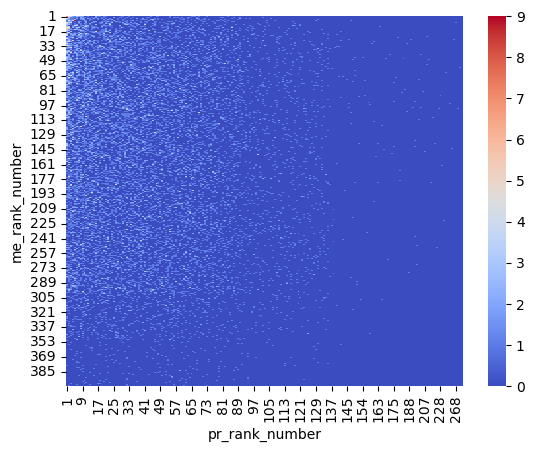

In [22]:
input_data_df['me_rank_number'] = input_data_df['me_rank_number'].astype(int)
input_data_df['pr_rank_number'] = input_data_df['pr_rank_number'].astype(int)

heatmap_data_me_pr = input_data_df.groupby(['me_rank_number', 'pr_rank_number']).size().unstack()
heatmap_data_me_pr = heatmap_data_me_pr.fillna(0)
plt.xlabel('pr_rank_number')
plt.ylabel('me_rank_number')
sns.heatmap(heatmap_data_me_pr, cmap='coolwarm')
plt.show()

In [23]:
input_data_df.head()

,ID_MING_JINSHI,personid,name,entry_year,pr_rank_number,me_rank_number,pl_rank_number
0,JINSHI_1-120.csv_1,34414,吳伯宗,1371,1,24,1.001
1,JINSHI_1-120.csv_2,198025,郭翀,1371,8,51,1.002
2,JINSHI_1-120.csv_3,198026,吳公達,1371,29,115,1.003
3,JINSHI_1-120.csv_4,66504,楊自立,1371,8,3,2.001
4,JINSHI_1-120.csv_5,198027,趙友能,1371,28,73,2.002


In [24]:
heatmap_data_me_pr

pr_rank_number,1,2,3,4,5,6,7,8,9,10,...,234,236,238,242,246,250,268,276,278,295
me_rank_number,,,,,,,,,,,,,,,,,,,,,
1,7.0,4.0,4.0,2.0,1.0,3.0,2.0,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9.0,3.0,1.0,1.0,1.0,1.0,0.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,2.0,1.0,1.0,0.0,2.0,0.0,2.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.0,2.0,1.0,1.0,3.0,0.0,0.0,1.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,4.0,2.0,4.0,9.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
398,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Heatmap of the relationship between me_rank 會試名次 <=100 and pr_rank 鄉試名次

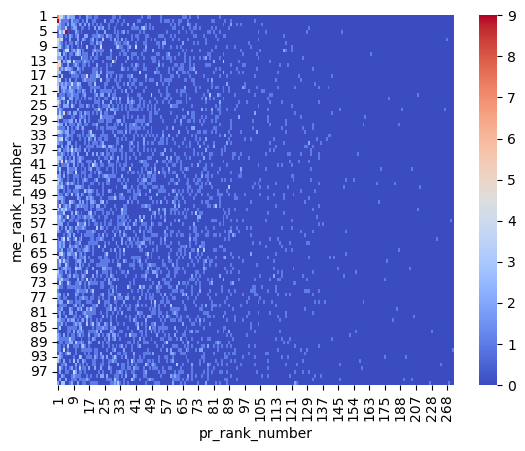

In [25]:
# Heatmap of the relationship between me_rank 會試名次 <=100 and pr_rank 鄉試名次
heatmap_data_me_pr_lt_100 = heatmap_data_me_pr.loc[heatmap_data_me_pr.index <= 100]
plt.xlabel('pr_rank_number')
plt.ylabel('me_rank_number')
sns.heatmap(heatmap_data_me_pr_lt_100, cmap='coolwarm')
plt.show()

In [26]:
input_data_df.head()

,ID_MING_JINSHI,personid,name,entry_year,pr_rank_number,me_rank_number,pl_rank_number
0,JINSHI_1-120.csv_1,34414,吳伯宗,1371,1,24,1.001
1,JINSHI_1-120.csv_2,198025,郭翀,1371,8,51,1.002
2,JINSHI_1-120.csv_3,198026,吳公達,1371,29,115,1.003
3,JINSHI_1-120.csv_4,66504,楊自立,1371,8,3,2.001
4,JINSHI_1-120.csv_5,198027,趙友能,1371,28,73,2.002


## Heatmap of the relationship between pl_rank 殿試名次 and me_rank 會試名次

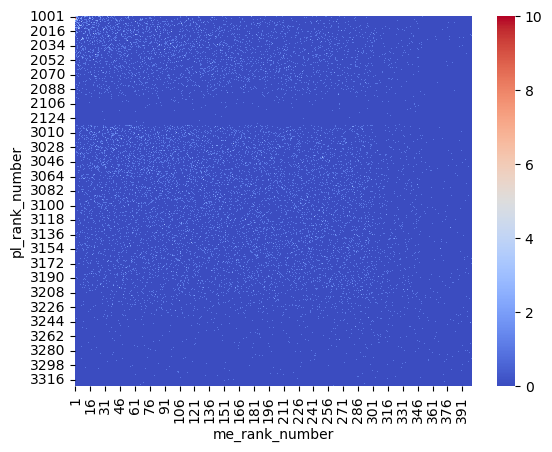

In [27]:
modified_data_df = input_data_df.copy()
# modified_data_df['pl_rank_number'] *= 1000
# modified_data_df['pl_rank_number'] = modified_data_df['pl_rank_number'].astype(int)
modified_data_df['pl_rank_number'] = round(modified_data_df['pl_rank_number'] * 1000).astype(int)
heatmap_data_pl_pr = modified_data_df.groupby(['pl_rank_number', 'me_rank_number']).size().unstack()
heatmap_data_pl_pr = heatmap_data_pl_pr.fillna(0)
plt.xlabel('me_rank_number')
plt.ylabel('pl_rank_number')
# plt.imshow(heatmap_data_pl_pr, cmap='hot', interpolation='nearest')
sns.heatmap(heatmap_data_pl_pr, cmap='coolwarm')
plt.show()

In [28]:
modified_data_df.head()

,ID_MING_JINSHI,personid,name,entry_year,pr_rank_number,me_rank_number,pl_rank_number
0,JINSHI_1-120.csv_1,34414,吳伯宗,1371,1,24,1001
1,JINSHI_1-120.csv_2,198025,郭翀,1371,8,51,1002
2,JINSHI_1-120.csv_3,198026,吳公達,1371,29,115,1003
3,JINSHI_1-120.csv_4,66504,楊自立,1371,8,3,2001
4,JINSHI_1-120.csv_5,198027,趙友能,1371,28,73,2002


# Heatmap of the relationship between pl_rank 殿試名次第一甲 <2000 and me_rank 會試名次

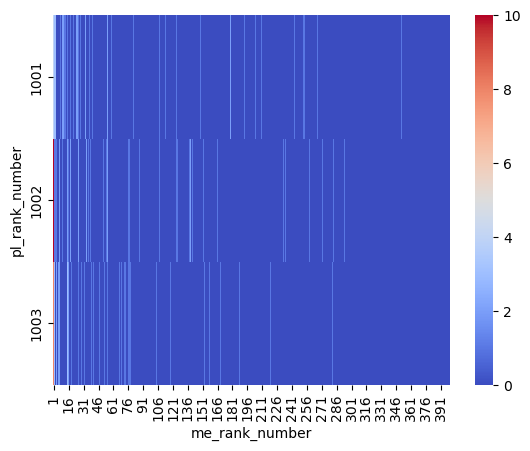

In [29]:
heatmap_data_pl_pr_lt_2000 = heatmap_data_pl_pr.loc[heatmap_data_pl_pr.index <= 2000]
plt.xlabel('me_rank_number')
plt.ylabel('pl_rank_number')
sns.heatmap(heatmap_data_pl_pr_lt_2000, cmap='coolwarm')
plt.show()

## Heatmap of the relationship between pl_rank 殿試名次第二甲 >=2000 and <3000 and me_rank 會試名次

<AxesSubplot:xlabel='me_rank_number', ylabel='pl_rank_number'>

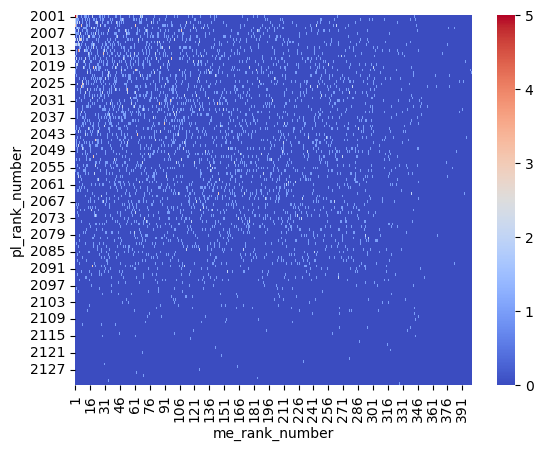

In [30]:
heatmap_data_pl_pr_ge_2000_lt_3000 = heatmap_data_pl_pr.loc[(heatmap_data_pl_pr.index >= 2000) & (heatmap_data_pl_pr.index < 3000)]
plt.xlabel('me_rank_number')
plt.ylabel('pl_rank_number')
sns.heatmap(heatmap_data_pl_pr_ge_2000_lt_3000, cmap='coolwarm')

## Heatmap of the relationship between pl_rank 殿試名次第三甲 >=3000 and me_rank 會試名次

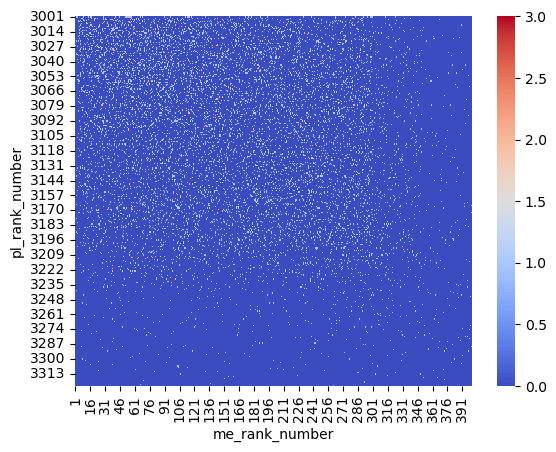

In [31]:
# Heatmap of the relationship between pl_rank 殿試名次第三甲 >=3000 and me_rank 會試名次
heatmap_data_pl_pr_ge_3000 = heatmap_data_pl_pr.loc[heatmap_data_pl_pr.index >= 3000]
plt.xlabel('me_rank_number')
plt.ylabel('pl_rank_number')
sns.heatmap(heatmap_data_pl_pr_ge_3000, cmap='coolwarm')
plt.show()

In [32]:
modified_data_df.head()

,ID_MING_JINSHI,personid,name,entry_year,pr_rank_number,me_rank_number,pl_rank_number
0,JINSHI_1-120.csv_1,34414,吳伯宗,1371,1,24,1001
1,JINSHI_1-120.csv_2,198025,郭翀,1371,8,51,1002
2,JINSHI_1-120.csv_3,198026,吳公達,1371,29,115,1003
3,JINSHI_1-120.csv_4,66504,楊自立,1371,8,3,2001
4,JINSHI_1-120.csv_5,198027,趙友能,1371,28,73,2002


In [33]:
heatmap_data_pl_pr

me_rank_number,1,2,3,4,5,6,7,8,9,10,...,391,392,393,394,395,396,397,398,399,400
pl_rank_number,,,,,,,,,,,,,,,,,,,,,
1001,4.0,3.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002,10.0,1.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003,8.0,3.0,0.0,2.0,0.0,2.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001,5.0,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2002,2.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3319,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3321,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Correlations of entry_year groups

In [34]:
year_interval = 30

# Create a new column 'entry_year_interval' by dividing 'entry_year' by year_interval and rounding down
input_data_df['entry_year_interval'] = input_data_df['entry_year'] // year_interval * year_interval
# Save input_data_df to a csv file
input_data_df.head()

,ID_MING_JINSHI,personid,name,entry_year,pr_rank_number,me_rank_number,pl_rank_number,entry_year_interval
0,JINSHI_1-120.csv_1,34414,吳伯宗,1371,1,24,1.001,1350
1,JINSHI_1-120.csv_2,198025,郭翀,1371,8,51,1.002,1350
2,JINSHI_1-120.csv_3,198026,吳公達,1371,29,115,1.003,1350
3,JINSHI_1-120.csv_4,66504,楊自立,1371,8,3,2.001,1350
4,JINSHI_1-120.csv_5,198027,趙友能,1371,28,73,2.002,1350


In [35]:
# Calcuate pearson correlation coefficient and pvalue for each year_interval
correlation_coefficient_list = []
correlation_p_value_list = []
for year in input_data_df['entry_year_interval'].unique():
    temp_df = input_data_df[input_data_df['entry_year_interval'] == year]
    pr_rank_number = temp_df['pr_rank_number']
    me_rank_number = temp_df['me_rank_number']
    pl_rank_number = temp_df['pl_rank_number']
    pearsonr_me_pr = pearsonr(me_rank_number, pr_rank_number)
    pearsonr_pl_pr = pearsonr(pl_rank_number, pr_rank_number)
    pearsonr_pl_me = pearsonr(pl_rank_number, me_rank_number)
    data_number = temp_df.shape[0]
    correlation_coefficient_list.append([pearsonr_me_pr[0], pearsonr_pl_pr[0], pearsonr_pl_me[0], data_number])
    correlation_p_value_list.append([pearsonr_me_pr[1], pearsonr_pl_pr[1], pearsonr_pl_me[1], data_number])

correlation_coefficient_df = pd.DataFrame(correlation_coefficient_list, columns=['metropolitan_provincial', 'palace_provincial', 'palace_metropolitan', "data_number"], index=input_data_df['entry_year_interval'].unique())
correlation_p_value_df = pd.DataFrame(correlation_p_value_list, columns=['metropolitan_provincial', 'palace_provincial', 'palace_metropolitan', "data_number"], index=input_data_df['entry_year_interval'].unique())

correlation_coefficient_df = correlation_coefficient_df.sort_index()
correlation_p_value_df = correlation_p_value_df.sort_index()

In [36]:
correlation_p_value_df

,metropolitan_provincial,palace_provincial,palace_metropolitan,data_number
1350,0.623879,0.642551,1.859445e-01,62
1380,0.418075,0.239680,4.099069e-03,109
1410,0.114819,0.526828,5.055697e-04,336
1440,0.000005,0.103154,8.315839e-13,2238
1470,0.003666,0.001001,3.677759e-12,2387
1500,0.000023,0.085319,1.404573e-11,1843
1530,0.000351,0.175246,1.304696e-19,3170
1560,0.000017,0.001441,1.887709e-27,3085
1590,0.417508,0.994437,3.531217e-02,230


In [37]:
correlation_coefficient_df

,metropolitan_provincial,palace_provincial,palace_metropolitan,data_number
1350,0.063505,0.060115,0.170215,62
1380,0.078345,0.113565,0.272847,109
1410,0.086188,0.034644,0.188724,336
1440,0.096151,0.034459,0.150484,2238
1470,0.059449,0.067301,0.141590,2387
1500,0.098375,0.040091,0.156540,1843
1530,0.063449,0.024082,0.159942,3170
1560,0.077319,0.057343,0.193661,3085
1590,0.053714,-0.000462,0.138867,230
